In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [3]:
def load_images(root_path, file_names, flatten=True, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if flatten:
            img = img.reshape((-1, 3))
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

In [6]:
root_path = 'data'

In [7]:
img_files = os.listdir(root_path)
if '.DS_Store' in img_files:
    img_files.pop(img_files.index('.DS_Store'))
img_files

['lena_color_256.tif']

In [8]:
img_original = load_images(root_path, img_files, flatten=False, normalize=False)
img_original

[array([[[226, 137, 125],
         [223, 136, 130],
         [226, 133, 118],
         ...,
         [230, 145, 127],
         [232, 148, 122],
         [210, 114, 100]],
 
        [[226, 137, 125],
         [223, 136, 130],
         [226, 133, 118],
         ...,
         [230, 145, 127],
         [232, 148, 122],
         [210, 114, 100]],
 
        [[226, 138, 124],
         [223, 133, 121],
         [226, 134, 117],
         ...,
         [222, 133, 118],
         [217, 125, 108],
         [182,  87,  90]],
 
        ...,
 
        [[ 90,  28,  61],
         [ 91,  28,  61],
         [ 97,  29,  63],
         ...,
         [140,  53,  71],
         [158,  62,  73],
         [161,  59,  74]],
 
        [[ 85,  20,  60],
         [ 91,  25,  59],
         [ 94,  26,  62],
         ...,
         [153,  64,  82],
         [172,  69,  81],
         [170,  65,  78]],
 
        [[ 82,  22,  57],
         [ 94,  30,  62],
         [ 95,  25,  61],
         ...,
         [167,  71,  84],
  

In [9]:
img_list = load_images(root_path, img_files, flatten=True, normalize=True)
img_list

[array([[0.88627451, 0.5372549 , 0.49019608],
        [0.8745098 , 0.53333333, 0.50980392],
        [0.88627451, 0.52156863, 0.4627451 ],
        ...,
        [0.65490196, 0.27843137, 0.32941176],
        [0.69803922, 0.26666667, 0.30588235],
        [0.71764706, 0.28235294, 0.31764706]])]

In [10]:
img_original[0].shape, img_list[0].shape

((256, 256, 3), (65536, 3))

In [11]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)        
kmeans.fit(img_list[0])

KMeans(n_clusters=5)

In [12]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
labels, centroids

(array([1, 1, 1, ..., 0, 0, 0], dtype=int32),
 array([[0.62196271, 0.26001059, 0.34211986],
        [0.83966505, 0.53085356, 0.4848006 ],
        [0.38756771, 0.10765601, 0.26755819],
        [0.79728636, 0.38463967, 0.38518782],
        [0.90159466, 0.74240429, 0.65082449]]))

In [13]:
bandwidth = estimate_bandwidth(img_list[0], quantile=0.08, n_samples=100)
print("bandwidth: ", str(bandwidth))
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(img_list[0])

bandwidth:  0.07933044104269463


MeanShift(bandwidth=0.07933044104269463, bin_seeding=True)

In [14]:
labels = meanshift.labels_
centroids = meanshift.cluster_centers_
labels, centroids

(array([2, 2, 2, ..., 3, 3, 3]),
 array([[0.36704589, 0.0915382 , 0.25418631],
        [0.81503342, 0.37968089, 0.37522419],
        [0.83348431, 0.51225711, 0.4724157 ],
        [0.68524502, 0.26741148, 0.31337403],
        [0.89043322, 0.7449037 , 0.68543467]]))

In [15]:
img_segmented = centroids[labels]*255
img_segmented = img_segmented.reshape(img_original[0].shape)

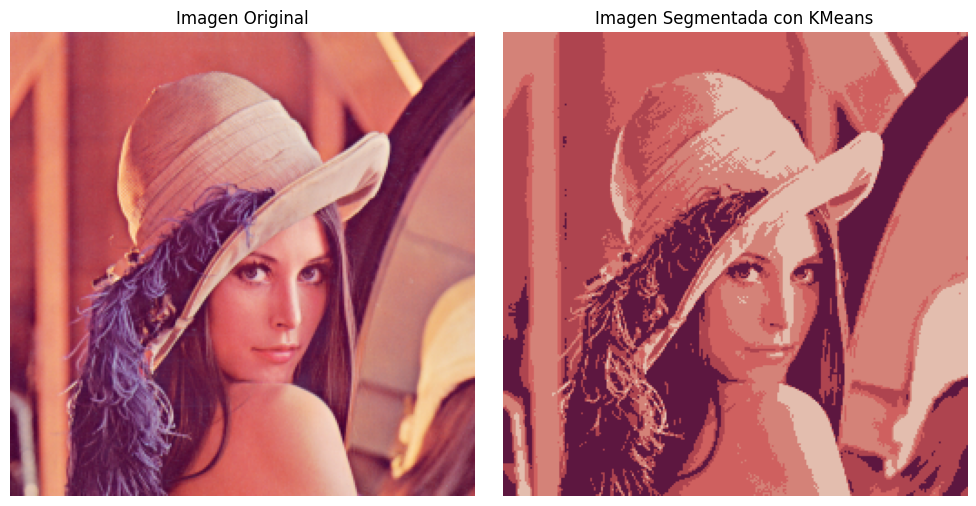

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_original[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Segmentada con KMeans')
plt.imshow(img_segmented.astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()

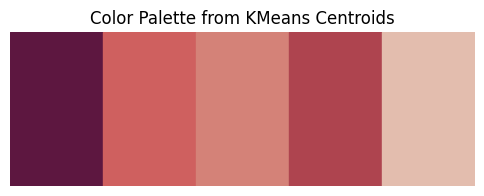

In [17]:
import matplotlib.patches as mpatches

# Convert centroids to integer RGB values
palette = (centroids * 255).astype(int)

# Display the palette
plt.figure(figsize=(6, 2))
for i, color in enumerate(palette):
    plt.gca().add_patch(
        mpatches.Rectangle((i, 0), 1, 1, color=color / 255)
    )
plt.xlim(0, len(palette))
plt.ylim(0, 1)
plt.axis('off')
plt.title('Color Palette from KMeans Centroids')
plt.show()